In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.ndimage as ndimage
from tqdm import tqdm_notebook
import community as cm
import networkx as nx
from collections import Counter
import pickle
from natsort import natsorted
from scipy.optimize import curve_fit

1000 2461


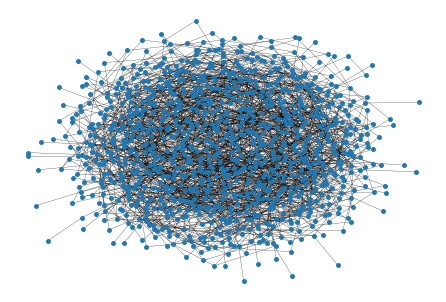

In [2]:
# g = nx.read_graphml('time_graphs/0/750.graphml')
g = nx.erdos_renyi_graph(1000, 0.005)
# g = nx.connected_watts_strogatz_graph(1500, 5, 0.15)
# g = nx.read_edgelist('real_graphs/email.txt', data=False)
layout = nx.kamada_kawai_layout(g)

communities = nx.algorithms.community.centrality.girvan_newman(g)
print(g.number_of_nodes(), g.number_of_edges())
nx.draw(g, pos=layout, node_size=15, width=0.25)

In [3]:
levels = []
for com in tqdm_notebook(communities):
    levels.append(com)

In [4]:
cluster_nodes = []
for i in "abcdefghijklmnopqrstuvwxyz":
    for j in "abcdefghijklmnopqrstuvwxyz":
        for k in "abcdefghijklmnopqrstuvwxyz":
            cluster_nodes.append(i + j + k)
            
dendro = nx.DiGraph()
dendro.add_node(tuple(g.nodes))

In [5]:
levels = [[tuple(sorted(x)) for x in sub] for sub in levels]
dendro.add_nodes_from(levels[0])
dendro.add_edges_from([(tuple(g.nodes), l) for l in levels[0]])

In [6]:
for i in range(len(levels) - 1):
    dendro.add_nodes_from(levels[i])
    split = list(set(levels[i]) - set(levels[i]).intersection(set(levels[i+1])))
    children = list(set(levels[i+1]) - set(levels[i]).intersection(set(levels[i+1])))
    dendro.add_edges_from([(split[0], c) for c in children])

1992 1991


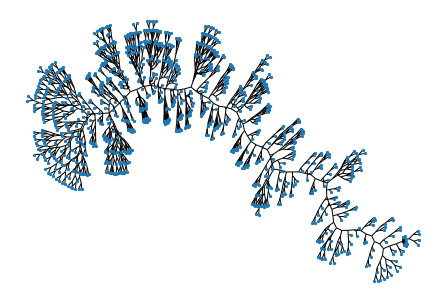

In [7]:
remap_dict = {}
counter = 0
draws = []
print(dendro.number_of_nodes(), dendro.number_of_edges())
for n in dendro.nodes:
    if len(n) > 1:
        remap_dict[n] = cluster_nodes[counter]
        counter += 1
    else:
        remap_dict[n] = n[0]
        draws.append(n[0])
        
remapped = nx.relabel_nodes(dendro, remap_dict)

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=5, nodelist=draws)
plt.savefig('erdos_renyi_dendro.png', dpi=2160)

[1.13184962 1.0801761 ]
0.9970897647525554


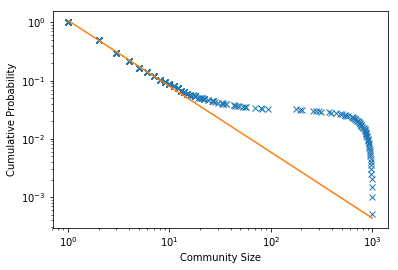

In [14]:
flattened = [x for y in levels for x in y]

flattened = list(set(flattened))

sizes = [len(x) for x in flattened]
sizes.append(g.number_of_nodes())

xs = sorted(sizes)
ys = [len([s for s in sizes if s >= m]) for m in xs]
ys = [y / len(sizes) for y in ys]

x_fits = xs[int(len(xs) * 0.5):]
y_fits = ys[int(len(ys) * 0.5):]

def hausdorff(lb, db, a):
    return a * lb**-db

popt = curve_fit(hausdorff, x_fits, y_fits)[0]
print(popt)

plt.xlabel('Community Size')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys, 'x')
curve_vals = [hausdorff(x, *popt) for x in xs]
plt.plot(xs, curve_vals)

y_fit = hausdorff(x_fits, *popt)

ss_res = np.sum((y_fits - y_fit) ** 2)

# total sum of squares
ss_tot = np.sum((y_fits - np.mean(y_fits)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

In [26]:
root = 'aaa'
nx.set_node_attributes(remapped, 0, 'hs')

# def compute_hs(node):
#     if not list(remapped.neighbors(node)):
#         remapped.node[node]['hs'] = 1
#     else:
#         children = list(remapped.neighbors(node))
#         if remapped.node[children[0]]['hs'] == 0:
#             compute_hs(children[0])
#         if remapped.node[children[1]]['hs'] == 0:
#             compute_hs(children[1])
#         if remapped.node[children[0]]['hs'] == remapped.node[children[1]]['hs']:
#             remapped.node[node]['hs'] = remapped.node[children[0]]['hs'] + 1
#         else:
#             remapped.node[node]['hs'] = max([remapped.node[children[0]]['hs'], remapped.node[children[1]]['hs']])
            
ratios = []
    
def compute_hs(node):
    if not list(remapped.neighbors(node)):
        ratios.append(1)
        return 1
    children = list(remapped.neighbors(node))
    
    for i in range(len(children)):
        if remapped.node[children[i]]['hs'] == 0:
            remapped.node[children[i]]['hs'] = compute_hs(children[i])
    
    if len(set([remapped.node[children[i]]['hs'] for i in range(len(children))])) == 1:
        ratios.append(remapped.node[children[0]]['hs'] + 1)
        return remapped.node[children[0]]['hs'] + 1
    return max([remapped.node[children[i]]['hs'] for i in range(len(children))])
            
remapped.node[root]['hs'] = compute_hs(root)
remapped.node[root]['hs']

7

('aaa', 'aab')
(7, 7)
7 1


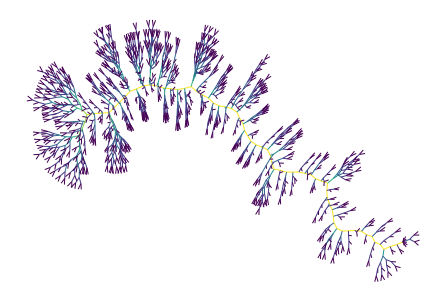

In [27]:
print(e)
print((remapped.node[e[0]]['hs'], remapped.node[e[1]]['hs']))

hs_colors = [min(remapped.node[e[0]]['hs'], remapped.node[e[1]]['hs']) for e in list(remapped.edges)]
print(max(hs_colors), min(hs_colors))

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=0, nodelist=draws, edge_color=hs_colors, node_color='black')
plt.savefig('er_bifurcations.png', dpi=2160)

In [28]:
Counter(ratios)

Counter({1: 1000, 2: 389, 3: 150, 4: 49, 5: 12, 6: 2, 7: 1})

In [32]:
# vals = Counter(nx.get_node_attributes(remapped, 'hs').values())
vals = Counter(ratios)
bs = [vals[i+1] / vals[i+2] for i in range(len(vals) - 1)]
print(bs)
np.mean(bs), np.std(bs)

[2.570694087403599, 2.5933333333333333, 3.061224489795918, 4.083333333333333, 6.0, 2.0]


(3.3847642073110307, 1.3315892711508162)

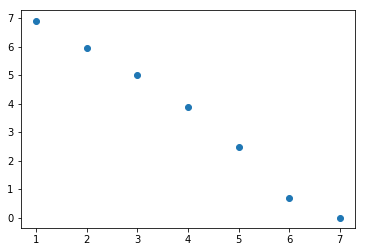

In [30]:
xs = list(Counter(ratios).values())
xs = [np.log(x) for x in xs]

plt.scatter(np.arange(1, len(xs) + 1), xs)

C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


[1.40023415 0.1545103 ]
0.8783891064844371


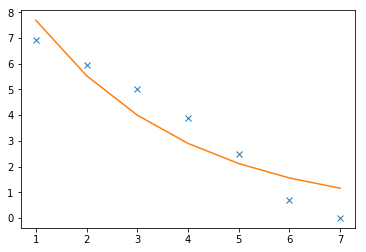

In [35]:
y3 = [np.log(x) for x in xs]
y3 = xs
x3 = np.arange(1, len(vals) + 1)

def hausdorff(x, b, a):
    return a + b ** (7-x)

popt = curve_fit(hausdorff, x3, y3)[0]
print(popt)

# plt.xscale('log')
# plt.yscale('log')
plt.plot(x3, y3, 'x')
curve_vals = [hausdorff(x, *popt) for x in x3]
plt.plot(x3, curve_vals)

y_fit = hausdorff(x3, *popt)

ss_res = np.sum((y3 - y_fit) ** 2)

# total sum of squares
ss_tot = np.sum((y3 - np.mean(y3)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)